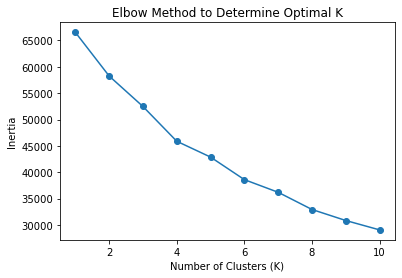

K=2: Silhouette Score = 0.2165115638745989
K=3: Silhouette Score = 0.13599860152622423
K=4: Silhouette Score = 0.15646070201421663
K=5: Silhouette Score = 0.1426384701200664
K=6: Silhouette Score = 0.1551279314687466
K=7: Silhouette Score = 0.16040945314374186
K=8: Silhouette Score = 0.16074220177672993
K=9: Silhouette Score = 0.16945296016627842
K=10: Silhouette Score = 0.17008207629656535


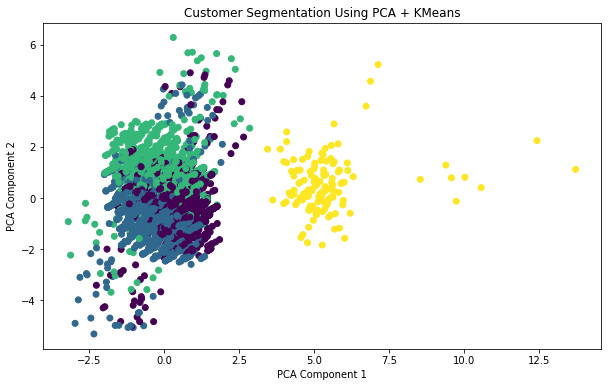

          Customer Email   Customer Name  Customer Age Customer Gender  \
0  aanderson@example.com    Robert Downs          42.0            Male   
1  aanderson@example.net    Cesar Jensen          35.0           Other   
2    aarnold@example.com     Angela Tran          52.0           Other   
3    aaron01@example.com  Justin Estrada          45.0          Female   
4    aaron49@example.org    James Santos          22.0           Other   

   Total_Tickets  Avg_Resolution_Hours  Avg_CSAT  HighPriority_pct  \
0              1              0.333333       3.0               0.0   
1              1              0.333333       3.0               1.0   
2              1           -739.750000       5.0               1.0   
3              1              0.333333       3.0               0.0   
4              1              0.333333       3.0               0.0   

  Primary_Channel         Primary_Issue  Gender_Encoded  Channel_Encoded  \
0    Social media       Billing inquiry               1   

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

data=pd.read_csv("customer_support_tickets.csv")

# STEP 1: PREPARE BASE DATA – CLEAN TIME COLUMNS
# Convert timestamps to datetime
data['First Response Time'] = pd.to_datetime(data['First Response Time'], errors='coerce')
data['Time to Resolution'] = pd.to_datetime(data['Time to Resolution'], errors='coerce')

# Compute total resolution time in hours
data['Resolution_Time_Hours'] = (
    data['Time to Resolution'] - data['First Response Time']
).dt.total_seconds() / 3600

# STEP 2: AGGREGATE DATA TO CUSTOMER LEVEL
# Convert ticket-level data → customer-level profile
customer_df = data.groupby('Customer Email').agg({
    'Customer Name':'first',                          # Keep name
    'Customer Age':'mean',                            # Average age
    'Customer Gender':'first',                        # Primary gender
    'Ticket ID':'count',                              # Total tickets raised
    'Resolution_Time_Hours':'mean',                   # Avg resolution hours
    'Customer Satisfaction Rating':'mean',            # Avg CSAT
    'Ticket Priority':lambda x: (x=='High').mean(),   # % high priority
    'Ticket Channel':lambda x: x.mode()[0],           # Most used channel
    'Ticket Type':lambda x: x.mode()[0]               # Most common issue
}).reset_index()

# Rename for clarity
customer_df.rename(columns={
    'Ticket ID':'Total_Tickets',
    'Resolution_Time_Hours':'Avg_Resolution_Hours',
    'Customer Satisfaction Rating':'Avg_CSAT',
    'Ticket Priority':'HighPriority_pct',
    'Ticket Channel':'Primary_Channel',
    'Ticket Type':'Primary_Issue'
}, inplace=True)

# STEP 3: HANDLE MISSING VALUES
customer_df['Customer Age'] = customer_df['Customer Age'].fillna(customer_df['Customer Age'].median())
customer_df['Avg_CSAT'] = customer_df['Avg_CSAT'].fillna(customer_df['Avg_CSAT'].median())
customer_df['Avg_Resolution_Hours'] = customer_df['Avg_Resolution_Hours'].fillna(customer_df['Avg_Resolution_Hours'].median())

# STEP 4: ENCODE CATEGORICAL VARIABLES
le_gender = LabelEncoder()
customer_df['Gender_Encoded'] = le_gender.fit_transform(customer_df['Customer Gender'])

le_channel = LabelEncoder()
customer_df['Channel_Encoded'] = le_channel.fit_transform(customer_df['Primary_Channel'])

le_issue = LabelEncoder()
customer_df['Issue_Encoded'] = le_issue.fit_transform(customer_df['Primary_Issue'])

# STEP 5: SELECT FEATURES FOR CLUSTERING
# Final numeric dataset for clustering
final_features = customer_df[[
    'Customer Age',
    'Total_Tickets',
    'Avg_Resolution_Hours',
    'Avg_CSAT',
    'HighPriority_pct',
    'Gender_Encoded',
    'Channel_Encoded',
    'Issue_Encoded'
]]

# STEP 6: SCALE DATA (MANDATORY FOR K-MEANS)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(final_features)

# STEP 7: ELBOW METHOD – FIND BEST NUMBER OF CLUSTERS
inertia = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_data)
    inertia.append(km.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title("Elbow Method to Determine Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.show()

# STEP 8: SILHOUETTE SCORE – VALIDATE BEST K
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(scaled_data)
    score = silhouette_score(scaled_data, labels)
    print(f"K={k}: Silhouette Score = {score}")

# STEP 9: FINAL K-MEANS CLUSTERING
best_k = 4 

final_kmeans = KMeans(n_clusters=best_k, random_state=42)
customer_df['Cluster'] = final_kmeans.fit_predict(scaled_data)

# STEP 10: DIMENSIONALITY REDUCTION FOR VISUALIZATION

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

customer_df['PCA1'] = pca_result[:, 0]
customer_df['PCA2'] = pca_result[:, 1]

# STEP 11: PLOT CLUSTERS

plt.figure(figsize=(10, 6))
plt.scatter(customer_df['PCA1'], customer_df['PCA2'], c=customer_df['Cluster'], cmap='viridis')
plt.title("Customer Segmentation Using PCA + KMeans")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# STEP 12: SHOW FINAL CUSTOMER CLUSTERED DATA

print(customer_df.head())


In [5]:
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(scaled_data)
    score = silhouette_score(scaled_data, labels)
    print(f"K={k}: Silhouette Score = {score}")

K=2: Silhouette Score = 0.2165115638745989
K=3: Silhouette Score = 0.13599860152622423
K=4: Silhouette Score = 0.15646070201421663
K=5: Silhouette Score = 0.1426384701200664
K=6: Silhouette Score = 0.1551279314687466
K=7: Silhouette Score = 0.16040945314374186
K=8: Silhouette Score = 0.16074220177672993
K=9: Silhouette Score = 0.16945296016627842
K=10: Silhouette Score = 0.17008207629656535


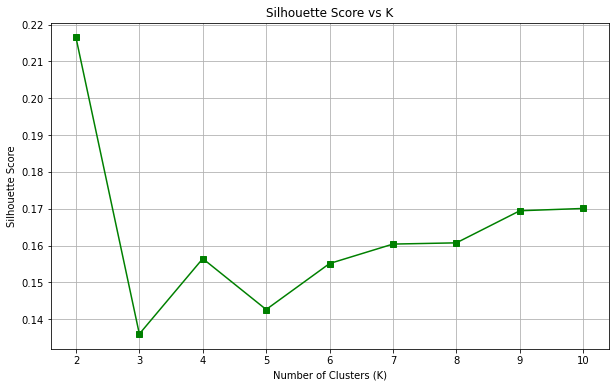

K = 2, Silhouette Score = 0.217
K = 3, Silhouette Score = 0.136
K = 4, Silhouette Score = 0.156
K = 5, Silhouette Score = 0.143
K = 6, Silhouette Score = 0.155
K = 7, Silhouette Score = 0.160
K = 8, Silhouette Score = 0.161
K = 9, Silhouette Score = 0.169
K = 10, Silhouette Score = 0.170


In [6]:
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_data)
    score = silhouette_score(scaled_data, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, marker='s', color='green')
plt.title('Silhouette Score vs K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

for k, score in zip(K, silhouette_scores):
    print(f"K = {k}, Silhouette Score = {score:.3f}")